## VGG16 Transfer Learning Classifier

This model implements a transfer learning pipeline using a pretrained VGG16 convolutional neural network.  
The VGG backbone is used as a fixed feature extractor, while a custom classification head is trained on the target dataset.

Images are resized and normalized before being passed through the network.  
Global average pooling is used to compress feature maps, followed by a Dense softmax layer for multi-class classification.

The training pipeline includes dataset streaming, batching, and evaluation with confusion matrix analysis.  
The implementation is heavily commented to explain each stage of the workflow, from preprocessing to model evaluation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Tensor flow -> deep neural network framework. Keras is TensorFlow’s user-friendly neural network interface.
# All types of layers imported. Models use layers like model.dense. Applicatioins refer to pretrained models
from tensorflow.keras import layers, models, optimizers, applications
# k has low level math operations
from tensorflow.keras import backend as K
# these are ways to define a neural network. Sequential is like a stack of layers. Model is used
# for advanced applications like multiple inputs for one output
from tensorflow.keras import Input, Model, Sequential

# Layers
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D
)

# Optimizers
from tensorflow.keras.optimizers import Adam, SGD

# Callbacks
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateScheduler,
    TensorBoard
)


In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

TRAIN_DIR = 'plant_village/train/'
VAL_DIR   = 'plant_village/val/'
TEST_DIR  = 'plant_village/test/'


# shuffle=True for training because we want random order each epoch
# → prevents the model from memorizing data order
# → improves generalization
#
# shuffle=False for validation/test because we want consistency
# → same data order every time
# → stable and reproducible evaluation
# → easier to compare predictions with ground truth
#
# training = learning → randomness helps
# validation/test = measuring → consistency matters

# "categorical"
# → one-hot encoded vectors
# → example (3 classes):
#    cat  = [1,0,0]
#    dog  = [0,1,0]
#    bird = [0,0,1]
# → used for multi-class classification with softmax

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=1,
    label_mode="categorical",
    shuffle=False
)
print(train_ds.class_names)



Found 3002 files belonging to 4 classes.
Found 635 files belonging to 4 classes.
Found 546 files belonging to 4 classes.
['Apple_Frogeye_Spot', 'Apple___Apple_scab', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [ ]:

# Rescaling layer converts pixel values from [0,255] → [0,1]
# dataset.map() applies a function to every batch in the pipeline
# lambda x,y: normalize images (x) but keep labels (y) unchanged
# returns a new dataset with normalized images
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# buffer size = how many batches are prepared ahead of time
#
# prefetch(buffer_size)
# means TensorFlow keeps N future batches ready in memory
#
# example:
# prefetch(1) → always keep 1 batch ready
# prefetch(5) → keep 5 batches queued
#
# larger buffer = smoother pipeline
# but uses more RAM
# AUTOTUNE lets TensorFlow automatically optimize pipeline performance
# prefetch() loads the next batch while the model is training
# → reduces GPU idle time
# → improves training speed
# TensorFlow decides the best buffer size dynamically

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

from tensorflow.keras.applications import VGG16


#We need to check the img size of our dataset and make sure it is that which supports vgg 16. NOTE : we already reshaped our dataset above by setting image size IMAGESIZE.

for images, _ in train_ds.take(1):
    print(images.shape[1], images.shape[2])

128 128


2026-02-03 21:45:15.728024: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:

# load the VGG16 model
base_model = VGG16(

    # load pretrained weights trained on ImageNet dataset
    # (millions of images → strong feature extractor)
    weights="imagenet",

    # remove the original classification head (Dense layers)
    # we only keep convolutional feature extractor
    include_top=False,

    # expected input image shape (H, W, channels)
    # must match dataset image size
    input_shape=(128, 128, 3)
)


# freeze all layers in VGG16
# prevents pretrained weights from being updated during training
# used in transfer learning (feature extraction mode)
base_model.trainable = False


# prints architecture summary:
# layers, output shapes, parameter counts
# parameters = learnable numbers inside the model
# they are weights + biases
# training = adjusting these numbers to reduce error
# more parameters = more flexibility + more risk of overfitting
# pooling has 0 parameters as nothing is being learnt there, only dimension changes

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

#Now we add our own top layers to vgg 16.

# ----- VGG16 Transfer Learning Flow (Full Notes) -----
#
# Step 1: Input image
# We feed a 128×128 RGB image into the model
# shape = (128, 128, 3)
#
# inputs = Input(shape=(128,128,3))
# This defines the entry point of the neural network.
#
#
# Step 2: Feature extraction (VGG16)
# x = base_model(inputs)
#
# The pretrained VGG16 backbone processes the image.
# It does NOT classify.
# It only extracts visual features like:
# edges, textures, shapes, patterns
#
# Output is NOT a class.
# Output is a stack of feature maps:
# (height, width, channels)
#
# Example output shape:
# 4 × 4 × 512
#
# This means:
# 512 learned feature detectors
# each detector produces a 4×4 activation map
#
#
# Step 3: Global Average Pooling
# x = GlobalAveragePooling2D()(x)
#
# Dense layers require a 1D vector.
# CNN output is 3D.
#
# GAP converts:
# 4×4×512 → 1×1×512
#
# It averages each feature map into one value.
#
# This summarizes:
# "how strongly each feature exists"
# instead of remembering exact positions.
#
# GAP reduces parameters and prevents overfitting.
#
#
# Step 4: Dense classifier
# outputs = Dense(4, activation="softmax")(x)
#
# The Dense layer is the decision maker.
#
# It takes the 512 feature summary values
# and maps them to 4 class scores.
#
# softmax converts scores → probabilities
#
# Example output:
# [0.02, 0.91, 0.04, 0.03]
#
# Highest value = predicted class
#
#
# Step 5: Build final model
# model = Model(inputs, outputs)
#
# Connects everything into one pipeline:
#
# image
# → VGG feature extractor
# → pooling summary
# → classifier
# → prediction
#
#
# Summary intuition:
# VGG = eyes (sees patterns)
# GAP = summarizes what was seen
# Dense = brain decides class
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(4, activation="softmax")(x)
# Model() creates a neural network object
# using the Functional API

# inputs = starting tensor (entry point)
# outputs = final tensor (prediction)

# Model connects the computation graph:
# input → layers → output

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

# ----- Model Compile + Training Notes -----
#
# Model architecture defines structure,
# but compile() defines HOW the model learns.
#
# compile = attach training rules to the model
# without compile → model.fit() cannot run
#
# model.compile includes:
#
# 1. Optimizer
# optimizer = Adam(learning_rate=0.001)
#
# optimizer controls how weights are updated
# during training (gradient descent step size)
#
# Adam = adaptive optimizer
# adjusts learning rate automatically
#
# learning_rate = how big each update step is
# too big → unstable learning
# too small → very slow training
#
#
# 2. Loss function
# loss = categorical_crossentropy
#
# loss measures prediction error
# training tries to minimize this value
#
# categorical_crossentropy is used when:
# - multi-class classification
# - softmax output
# - one-hot encoded labels
#
#
# 3. Metrics
# metrics = ['accuracy']
#
# metrics are for monitoring only
# they DO NOT affect learning
# accuracy = % correct predictions
#
#
# model.fit() starts the training loop
#
# for each batch:
#   predict output
#   compute loss
#   backpropagate error
#   update weights
#
# validation_data is used only for evaluation
# weights are NOT updated on validation set
#
#
# epochs = number of full passes over dataset
#
# history object stores training logs:
# loss per epoch
# accuracy per epoch
# validation metrics
#
#
# summary:
# architecture = what the model is
# compile = how the model learns
# fit = make the model learn

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # 'acc' is deprecated in tf.keras
)

# Train the model
history = model.fit(
    train_ds,                     # tf.data.Dataset
    validation_data=val_ds,       # tf.data.Dataset
    epochs=30,
    verbose=1
)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 398ms/step - accuracy: 0.5976 - loss: 1.0275 - val_accuracy: 0.8142 - val_loss: 0.7608
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 387ms/step - accuracy: 0.8041 - loss: 0.6735 - val_accuracy: 0.8551 - val_loss: 0.5500
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 398ms/step - accuracy: 0.8491 - loss: 0.5198 - val_accuracy: 0.8803 - val_loss: 0.4412
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 389ms/step - accuracy: 0.8771 - loss: 0.4322 - val_accuracy: 0.9118 - val_loss: 0.3782
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 391ms/step - accuracy: 0.8944 - loss: 0.3765 - val_accuracy: 0.9323 - val_loss: 0.3360
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 384ms/step - accuracy: 0.9107 - loss: 0.3368 - val_accuracy: 0.9291 - val_loss: 0.3037
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 71s 376ms/step - accuracy: 0.9191 - loss: 0.3070 - val_accuracy: 0.9307 - val_loss: 0.2798
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 71s 377ms/step - accuracy: 0.9237 - loss: 0

In [ ]:
model.evaluate(test_ds)
model.save("plant_model.keras")


546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9249 - loss: 0.1829


In [ ]:
import numpy as np

# 1. GENERATE PREDICTIONS
# The model looks at the images in test_ds and outputs "confidence scores" (probabilities).
# verbose=1 shows the progress bar so you aren't staring at a blank screen.
predictions = model.predict(test_ds, verbose=1)

# Since 'predictions' contains probabilities for every class (e.g., [0.1, 0.8, 0.1]),
# np.argmax picks the index of the highest value (e.g., index 1).
predicted_classes = np.argmax(predictions, axis=1)

# 2. EXTRACT GROUND TRUTH (The "Answer Key")
# This loop goes through the dataset and pulls out the actual labels (y).
# .numpy() converts them from TensorFlow format to NumPy format for easier math.
# np.concatenate joins the batches together into one long array.
ground_truth = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# If the labels are "One-Hot Encoded" (like [0, 1, 0]), we need to simplify them.
# ground_truth.ndim > 1 checks if the labels are a 2D matrix instead of a 1D list.
if ground_truth.ndim > 1:
    # Just like with predictions, we pick the position of the "1" to get the class index.
    ground_truth = np.argmax(ground_truth, axis=1)

# 3. FIND ERRORS
# We compare the two arrays. '!=' finds everywhere they DON'T match.
# np.where returns the indices (positions) of those mismatches.
errors = np.where(predicted_classes != ground_truth)[0]

# 4. FINAL REPORT
# len(errors) is the count of mistakes; len(ground_truth) is the total images tested.
print("No of errors = {}/{}".format(len(errors), len(ground_truth)))

# Example of calculating Accuracy percentage:
accuracy = ((len(ground_truth) - len(errors)) / len(ground_truth)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step
No of errors = 41/546


2026-02-03 23:11:33.284526: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


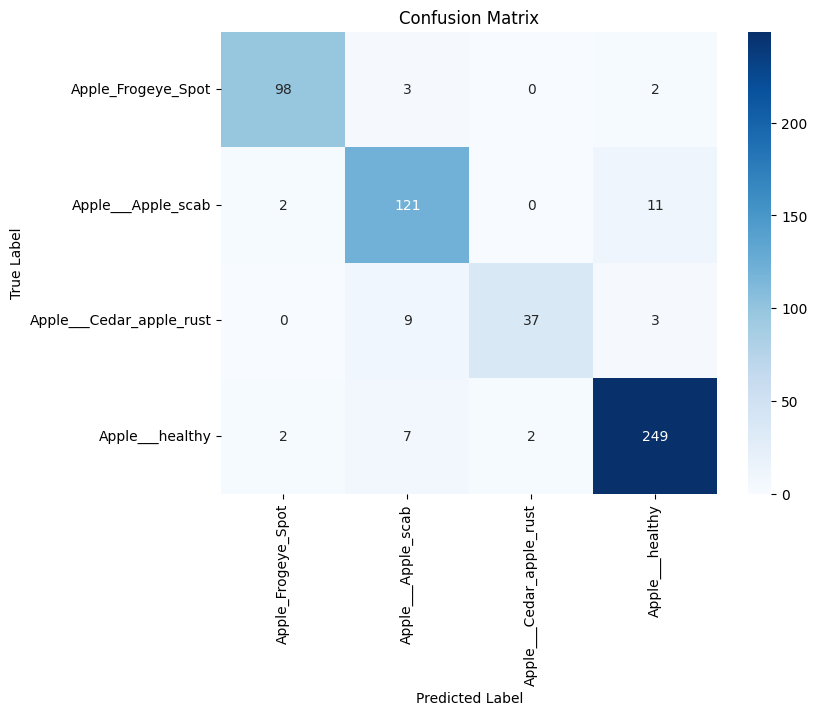

In [35]:
# Get class names from the directory
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = sorted(os.listdir('plant_village/train/'))
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
# Then use it in your confusion matrix code
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()